In [1]:
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm

%matplotlib inline

In [2]:
model_2_data = pd.read_csv('data/cleaned_kc_house_data.csv')

In [3]:
correlation_data = model_2_data.corr().abs()
unstacked_correlation_data = correlation_data.unstack()
srt_unstacked_correlation_data = unstacked_correlation_data.sort_values(ascending=False, kind='quicksort')

In [4]:
srt_unstacked_correlation_data.loc[(srt_unstacked_correlation_data != 1.0) & (srt_unstacked_correlation_data > .7)].head(20)

sqft_above     sqft_living      0.873747
sqft_living    sqft_above       0.873747
grade          sqft_living      0.758916
sqft_living    grade            0.758916
               sqft_living15    0.757754
sqft_living15  sqft_living      0.757754
sqft_above     grade            0.752974
grade          sqft_above       0.752974
sqft_living    bathrooms        0.750902
bathrooms      sqft_living      0.750902
sqft_above     sqft_living15    0.731980
sqft_living15  sqft_above       0.731980
sqft_lot       sqft_lot15       0.718085
sqft_lot15     sqft_lot         0.718085
sqft_living15  grade            0.714324
grade          sqft_living15    0.714324
dtype: float64

In [5]:
## Use variance inflation factor to test for multicollinearity amongst feature variables
independent_data = model_2_data.drop(['price'], axis=1)
vif = [variance_inflation_factor(independent_data.values, i) for i in range(len(independent_data.columns))]

In [6]:
list(zip(independent_data.columns, vif))

[('month', 5.443743334473656),
 ('bedrooms', 25.846347041046936),
 ('bathrooms', 29.05786076470624),
 ('sqft_living', 892.4167417171016),
 ('sqft_lot', 2.372879956183381),
 ('floors', 16.944587575065594),
 ('waterfront', 1.163482020190022),
 ('view', 1.4877794056617608),
 ('condition', 34.93445685579481),
 ('grade', 152.0738221688315),
 ('sqft_above', 669.9332264490171),
 ('sqft_basement', 46.508620920635),
 ('yr_built', 9430.428060786378),
 ('yr_renovated', 1.1547832074461881),
 ('zipcode', 1642034.7439469502),
 ('lat', 138857.00552906943),
 ('long', 1372623.126719834),
 ('sqft_living15', 27.52941031708486),
 ('sqft_lot15', 2.593700527713946)]

In [7]:
model_2_data.drop(['sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'], axis=1, inplace=True)

#### Create Dummy Variables for Seasons

In [8]:
## Bin 'month' column into seasons
labels = ['Winter', 'Spring', 'Summer', 'Fall', 'Winter']
model_2_data.month = pd.cut(model_2_data.month, bins=[0,2,5,8,11,12], labels=labels, ordered=False)

In [9]:
model_2_data.month.value_counts()

Spring    6469
Summer    6221
Fall      4971
Winter    3657
Name: month, dtype: int64

In [10]:
model_2_data.groupby('month')['price'].mean()

month
Fall      530505.811909
Spring    553723.661617
Summer    548311.498955
Winter    520428.259776
Name: price, dtype: float64

In [11]:
season_dummies = pd.get_dummies(model_2_data.month, prefix='Season')

In [12]:
## Reorder seasons based on chronology
## Exclude 'Season_Spring' to avoid the dummy variable trap
season_columns = list(season_dummies.columns)
season_columns = [season_columns[2]] + [season_columns[0]] + [season_columns[3]]
season_dummies = season_dummies[season_columns]

In [13]:
model_2_data = pd.concat([model_2_data, season_dummies], axis=1)

In [14]:
model_2_data.drop(['month'], axis=1, inplace=True)

#### Create Dummy Variables for Bedrooms

In [15]:
model_2_data.bedrooms.unique()

array([ 3,  2,  4,  5,  1,  6,  7,  8,  9, 11, 10], dtype=int64)

In [16]:
model_2_data.bedrooms.value_counts()

3     9714
4     6843
2     2700
5     1580
6      262
1      158
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

In [17]:
## Bin 'bedrooms' column
bedroom_labels = ['1', '2', '3', '4', '5', '6_up']
model_2_data.bedrooms = pd.cut(model_2_data.bedrooms, bins=[0,1,2,3,4,5,11], labels=bedroom_labels, ordered=True)

In [18]:
model_2_data.bedrooms.value_counts()

3       9714
4       6843
2       2700
5       1580
6_up     323
1        158
Name: bedrooms, dtype: int64

In [19]:
bedrooms_dummies = pd.get_dummies(model_2_data.bedrooms, prefix='Bedrooms', drop_first=True)

In [20]:
model_2_data = pd.concat([model_2_data, bedrooms_dummies], axis=1)
model_2_data.drop(['bedrooms'], axis=1, inplace=True)

#### Create Dummy Variables for Bathrooms

In [21]:
model_2_data.bathrooms = model_2_data.bathrooms.apply(np.floor)
model_2_data = model_2_data.astype({'bathrooms':'int'})

In [22]:
model_2_data.bathrooms.value_counts()

2    10477
1     8237
3     2215
4      332
5       44
6       11
8        1
7        1
Name: bathrooms, dtype: int64

In [23]:
## Bin 'bathrooms' column
bathroom_labels = ['1', '2', '3', '4', '5_up']
model_2_data.bathrooms = pd.cut(model_2_data.bathrooms, bins=[0,1,2,3,4,8], labels=bathroom_labels, ordered=True)

In [24]:
bathroom_dummies = pd.get_dummies(model_2_data.bathrooms, prefix='Bathrooms', drop_first=True)

In [25]:
model_2_data = pd.concat([model_2_data, bathroom_dummies], axis=1)
model_2_data.drop(['bathrooms'], axis=1, inplace=True)

#### Create Dummy Variables for Floors

In [26]:
model_2_data.floors = model_2_data.floors.apply(np.floor)
model_2_data = model_2_data.astype({'floors':'int'})

In [27]:
floor_dummies = pd.get_dummies(model_2_data.floors, prefix='Floors', drop_first=True)

In [28]:
model_2_data = pd.concat([model_2_data, floor_dummies], axis=1)
model_2_data.drop(['floors'], axis=1, inplace=True)

#### Create Dummy Variables for View

In [29]:
view_dummies = pd.get_dummies(model_2_data.view, prefix='View', drop_first=True)

In [30]:
model_2_data = pd.concat([model_2_data, view_dummies], axis=1)
model_2_data.drop(['view'], axis=1, inplace=True)

#### Create Dummy Variables for Condition

In [31]:
model_2_data.condition.unique()

array([3, 5, 4, 1, 2], dtype=int64)

In [32]:
condition_dummies = pd.get_dummies(model_2_data.condition, prefix='Condition', drop_first=True)

In [33]:
model_2_data = pd.concat([model_2_data, condition_dummies], axis=1)
model_2_data.drop(['condition'], axis=1, inplace=True)

#### Create Dummy Variables for Grade

In [34]:
model_2_data.grade.value_counts()

7     8871
8     6040
9     2606
6     1968
10    1130
11     396
5      219
12      88
Name: grade, dtype: int64

In [35]:
## Bin 'grade' column
grade_labels = ['Average', 'Above_Average', 'High_Quality']
model_2_data.grade = pd.cut(model_2_data.grade, bins=[4,7,9,12], labels=grade_labels, ordered=True)

In [36]:
grade_dummies = pd.get_dummies(model_2_data.grade, prefix='Grade', drop_first=True)

In [37]:
model_2_data = pd.concat([model_2_data, grade_dummies], axis=1)
model_2_data.drop(['grade'], axis=1, inplace=True)

#### Create Dummy Variables for Yr_Built

In [38]:
model_2_data.yr_built.describe()

count    21318.000000
mean      1971.211042
std         29.353097
min       1900.000000
25%       1952.000000
50%       1975.000000
75%       1997.000000
max       2015.000000
Name: yr_built, dtype: float64

In [39]:
## Bin 'yr_built' column
#yr_built_labels = ['1900-1925', '1926-1950', '1951-1975', '1976-2000', '2001-2015']
yr_built_labels = ['first_chunk', 'second_chunk', 'third_chunk', 'fourth_chunk', 'fifth_chunk']
model_2_data.yr_built = pd.cut(model_2_data.yr_built, bins=[1899,1925,1950,1975,2000,2015], labels=yr_built_labels)

In [40]:
yr_built_dummies = pd.get_dummies(model_2_data.yr_built, drop_first=True)

In [41]:
model_2_data = pd.concat([model_2_data, yr_built_dummies], axis=1)
model_2_data.drop(['yr_built'], axis=1, inplace=True)

#### Create Yr_renovated Column

In [42]:
model_2_data = model_2_data.astype({'yr_renovated':'int'})

In [43]:
def cnst_calc(dataFrame):
    if dataFrame['yr_renovated'] > 2004:
        val = 1
    else:
        val = 0
    return val

In [44]:
model_2_data['renovation_10'] = model_2_data.apply(cnst_calc, axis=1)
model_2_data.drop('yr_renovated', axis=1, inplace=True)

#### Bin Latitudes and Longitudes

In [45]:
## Remove these data to prevent creation of sections with very few homes sold
model_2_data = model_2_data.loc[model_2_data.long <= -121.69]

In [46]:
min_lat = model_2_data.lat.min()
max_lat = model_2_data.lat.max()
min_long = model_2_data.long.min()
max_long = model_2_data.long.max()
thirds_lat = (max_lat - min_lat) / 3
thirds_long = (max_long - min_long) / 3

In [47]:
model_2_data.rename(columns={'zipcode':'section'}, inplace=True)

In [48]:
def section_sorter(row):
    section_number = 0
    for each_third in range(3):
        high_lat = max_lat - thirds_lat*each_third
        low_lat = max_lat - thirds_lat*(each_third+1)
        for thirds in range(3):
            high_long = min_long + thirds_long*(thirds+1)
            low_long = min_long + thirds_long*thirds
            section_number += 1
            if row['lat']<=high_lat and row['lat']>=low_lat and row['long']<=high_long and row['long']>=low_long:
                return(section_number)

In [49]:
model_2_data.section = model_2_data.apply(section_sorter, axis=1)
model_2_data = model_2_data.astype({'section':'int'})

#### Create Dummy Variables for Section

In [50]:
section_dummies = pd.get_dummies(model_2_data.section, prefix='Section', drop_first=True)

In [51]:
model_2_data = pd.concat([model_2_data, section_dummies], axis=1)
model_2_data.to_csv('data/graph_data.csv', index=False)
model_2_data.drop(['section', 'lat', 'long'], axis=1, inplace=True)

## Model 2

In [52]:
target_variable = 'price'
input_variables = model_2_data.drop('price', axis=1).columns
formula = target_variable + '~' + '+'.join(input_variables)

In [53]:
model_2 = ols(formula=formula, data=model_2_data).fit()
model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.714
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     1330.
Date:                Wed, 22 Sep 2021   Prob (F-statistic):               0.00
Time:                        16:26:54   Log-Likelihood:            -2.8921e+05
No. Observations:               21301   AIC:                         5.785e+05
Df Residuals:                   21260   BIC:                         5.788e+05
Df Model:                          40                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            1.936e+05   4.01e+04      4.834      0.000    1.15e+05    2.72e+05
sqft_living           179.4467      2.821     63.613      0.000     173.918     184.976
sqft_lot               -0.0553      0.034     -1.640      0.101      -0.121       0.011
waterfront           5.073e+05   1.83e+04     27.680      0.000    4.71e+05    5.43e+05
Season_Summer       -2.587e+04   3399.145     -7.611      0.000   -3.25e+04   -1.92e+04
Season_Fall         -3.116e+04   3606.890     -8.640      0.000   -3.82e+04   -2.41e+04
Season_Winter       -2.577e+04   3955.281     -6.515      0.000   -3.35e+04    -1.8e+04
Bedrooms_2           6424.7294   1.57e+04      0.408      0.683   -2.44e+04    3.73e+04
Bedrooms_3          -2588.2374   1.56e+04     -0.166      0.868   -3.32e+04     2.8e+04
Bedrooms_4          -3.367e+04   1.59e+04     -2.113      0.035   -6.49e+04   -2442.601
Bedrooms_5          -4.693e+04   1.67e+04     -2.809      0.005   -7.97e+04   -1.42e+04
Bedrooms_6_up       -1.387e+05   1.95e+04     -7.118      0.000   -1.77e+05   -1.01e+05
Bathrooms_2          -264.4666   3799.840     -0.070      0.945   -7712.441    7183.507
Bathrooms_3          5.917e+04   6240.177      9.481      0.000    4.69e+04    7.14e+04
Bathrooms_4          2.102e+05   1.27e+04     16.534      0.000    1.85e+05    2.35e+05
Bathrooms_5_up       5.175e+05   2.72e+04     19.013      0.000    4.64e+05    5.71e+05
Floors_2             1.313e+04   3952.466      3.322      0.001    5384.053    2.09e+04
Floors_3             1.384e+04   9231.495      1.500      0.134   -4251.665    3.19e+04
View_1               1.425e+05   1.08e+04     13.222      0.000    1.21e+05    1.64e+05
View_2               9.035e+04   6535.761     13.824      0.000    7.75e+04    1.03e+05
View_3               1.576e+05   8888.310     17.733      0.000     1.4e+05    1.75e+05
View_4               3.276e+05   1.33e+04     24.661      0.000    3.02e+05    3.54e+05
Condition_2          9.163e+04   4.05e+04      2.263      0.024    1.23e+04    1.71e+05
Condition_3          9.519e+04   3.76e+04      2.532      0.011    2.15e+04    1.69e+05
Condition_4           1.34e+05   3.76e+04      3.561      0.000    6.02e+04    2.08e+05
Condition_5          1.706e+05   3.78e+04      4.510      0.000    9.64e+04    2.45e+05
Grade_Above_Average    8.4e+04   3577.247     23.482      0.000     7.7e+04     9.1e+04
Grade_High_Quality   3.483e+05   7370.554     47.261      0.000    3.34e+05    3.63e+05
second_chunk         -4.96e+04   5519.373     -8.987      0.000   -6.04e+04   -3.88e+04
third_chunk         -1.018e+05   5386.347    -18.904      0.000   -1.12e+05   -9.13e+04
fourth_chunk        -1.526e+05   6032.996    -25.299      0.000   -1.64e+05   -1.41e+05
fifth_chunk         -1.289e+05   6703.104    -19.231      0.000   -1.42e+05   -1.16e+05
ren

#### Assumption of Normality<br>&emsp;(for Model_2)

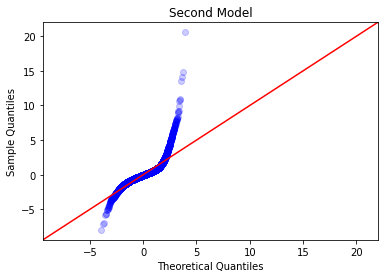

In [54]:
residuals = model_2.resid
fig = sm.graphics.qqplot(residuals, dist=stats.norm, fit=True, line='45', alpha=0.2)
plt.title('Second Model', size=12);

#### Assumption of Homoscedasticity<br>&emsp;(for Model_2)

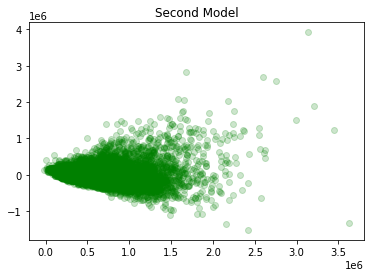

In [55]:
fig1,ax1 = plt.subplots()
ax1.scatter(x=model_2.predict(), y=residuals, color='green', alpha=0.2)
plt.title('Second Model', size=12);

In [56]:
model_2_data.to_csv('data/model_2_data.csv', index=False)